# Environment

#### Hypatia
* virtual env: source envs/pSEOBNRv4HM_tgr_injections/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection/etc/lal*.sh

#### Laptop
* virtual env: pyenv activate pSEOBNRv4HM_tgr_injections
* lalsuite: source .pyenv/versions/pSEOBNRv4HM_tgr_injections/opt/lalsuite_pSEOBNRv4HM_tgr_injection_20201106_d16da559/etc/lalsuiterc 

In [1]:
#%matplotlib notebook
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import pandas as pd
import corner

import lal
import lalsimulation as lalsim

import sys
sys.path.insert(0,'code')
sys.path.append('../../scripts')

import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import glob
import h5py
import seaborn as sns

from bounded_1d_kde import Bounded_1d_kde
from bounded_2d_kde import Bounded_2d_kde


plt.style.use("MATPLOTLIB_RCPARAMS.sty") 

In [2]:
# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)

    return Mf,jf

In [3]:
# data

event_list = ['GW150914', 'GW190521']
run_list = ['0p0', '0p5', '0p0_GR', '0p5_GR']

data_dict = {}

for event in event_list:
    data_dict[event] = {}
    
    for run in run_list:
        
        data_loc = glob.glob('../../runs/nonGR/%s-like/*_%s_widerdist/cbcBayes/posterior_samples.dat'%(event, run))[0]
        data_dict[event][run] = np.genfromtxt(data_loc, dtype=None, names=True)

### GW150914: 0p0: pSEOB vs SEOB comparison

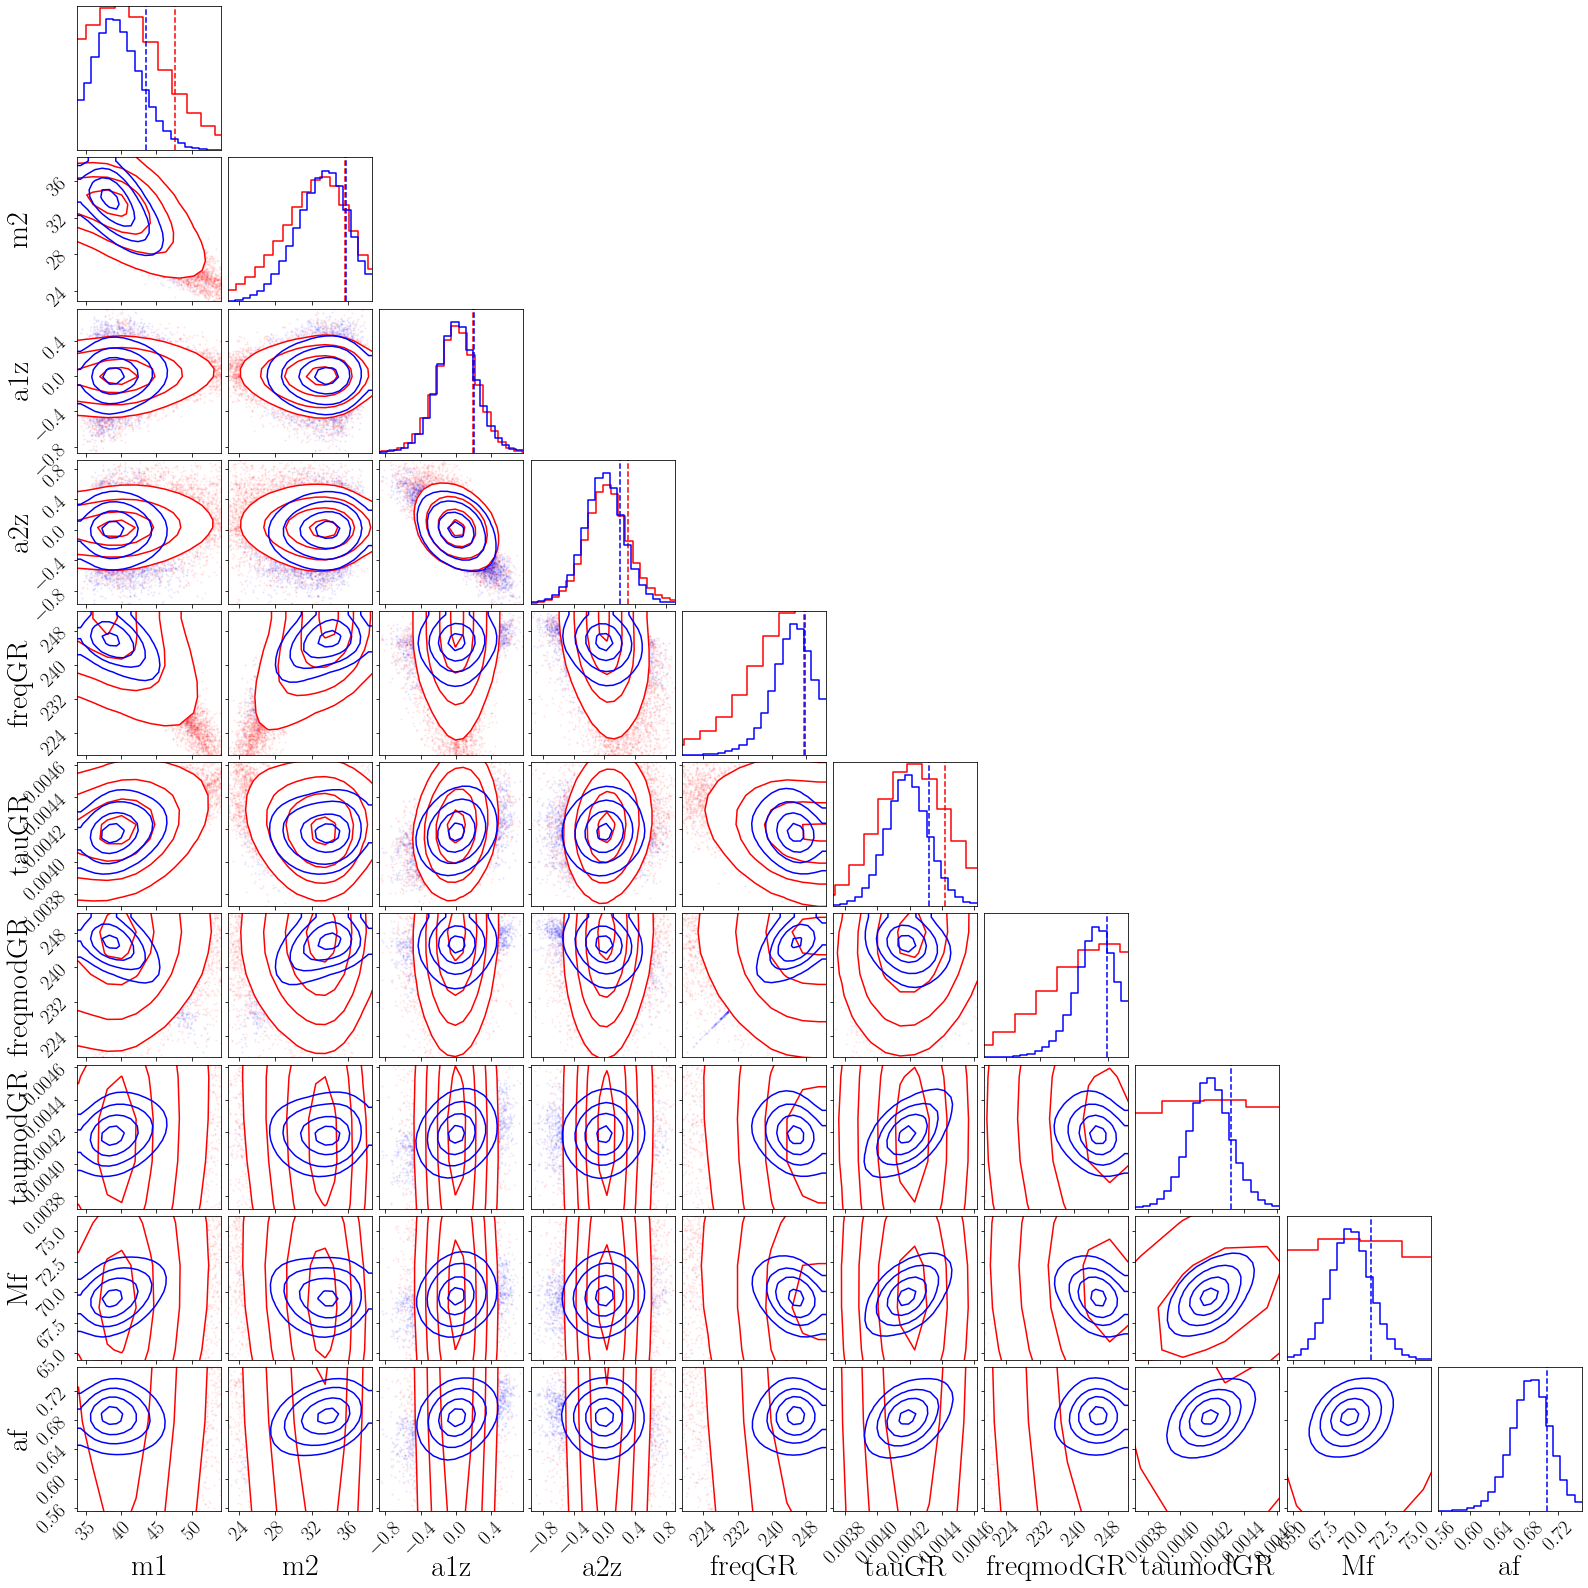

In [4]:
data = data_dict['GW150914']['0p0']
m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
samples_ngr = np.vstack([m1, m2, a1z, a2z, freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af]).T

data = data_dict['GW150914']['0p0_GR']
m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
samples_gr = np.vstack([m1, m2, a1z, a2z, freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af]).T

fig = corner.corner(samples_ngr, color='red', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None)
corner.corner(samples_gr, fig=fig, color='blue', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None, \
                    labels=['m1', 'm2', 'a1z', 'a2z', 'freqGR', 'tauGR', 'freqmodGR', 'taumodGR', 'Mf', 'af'])
plt.show()

### GW150914: 0p5: pSEOB vs SEOB comparison

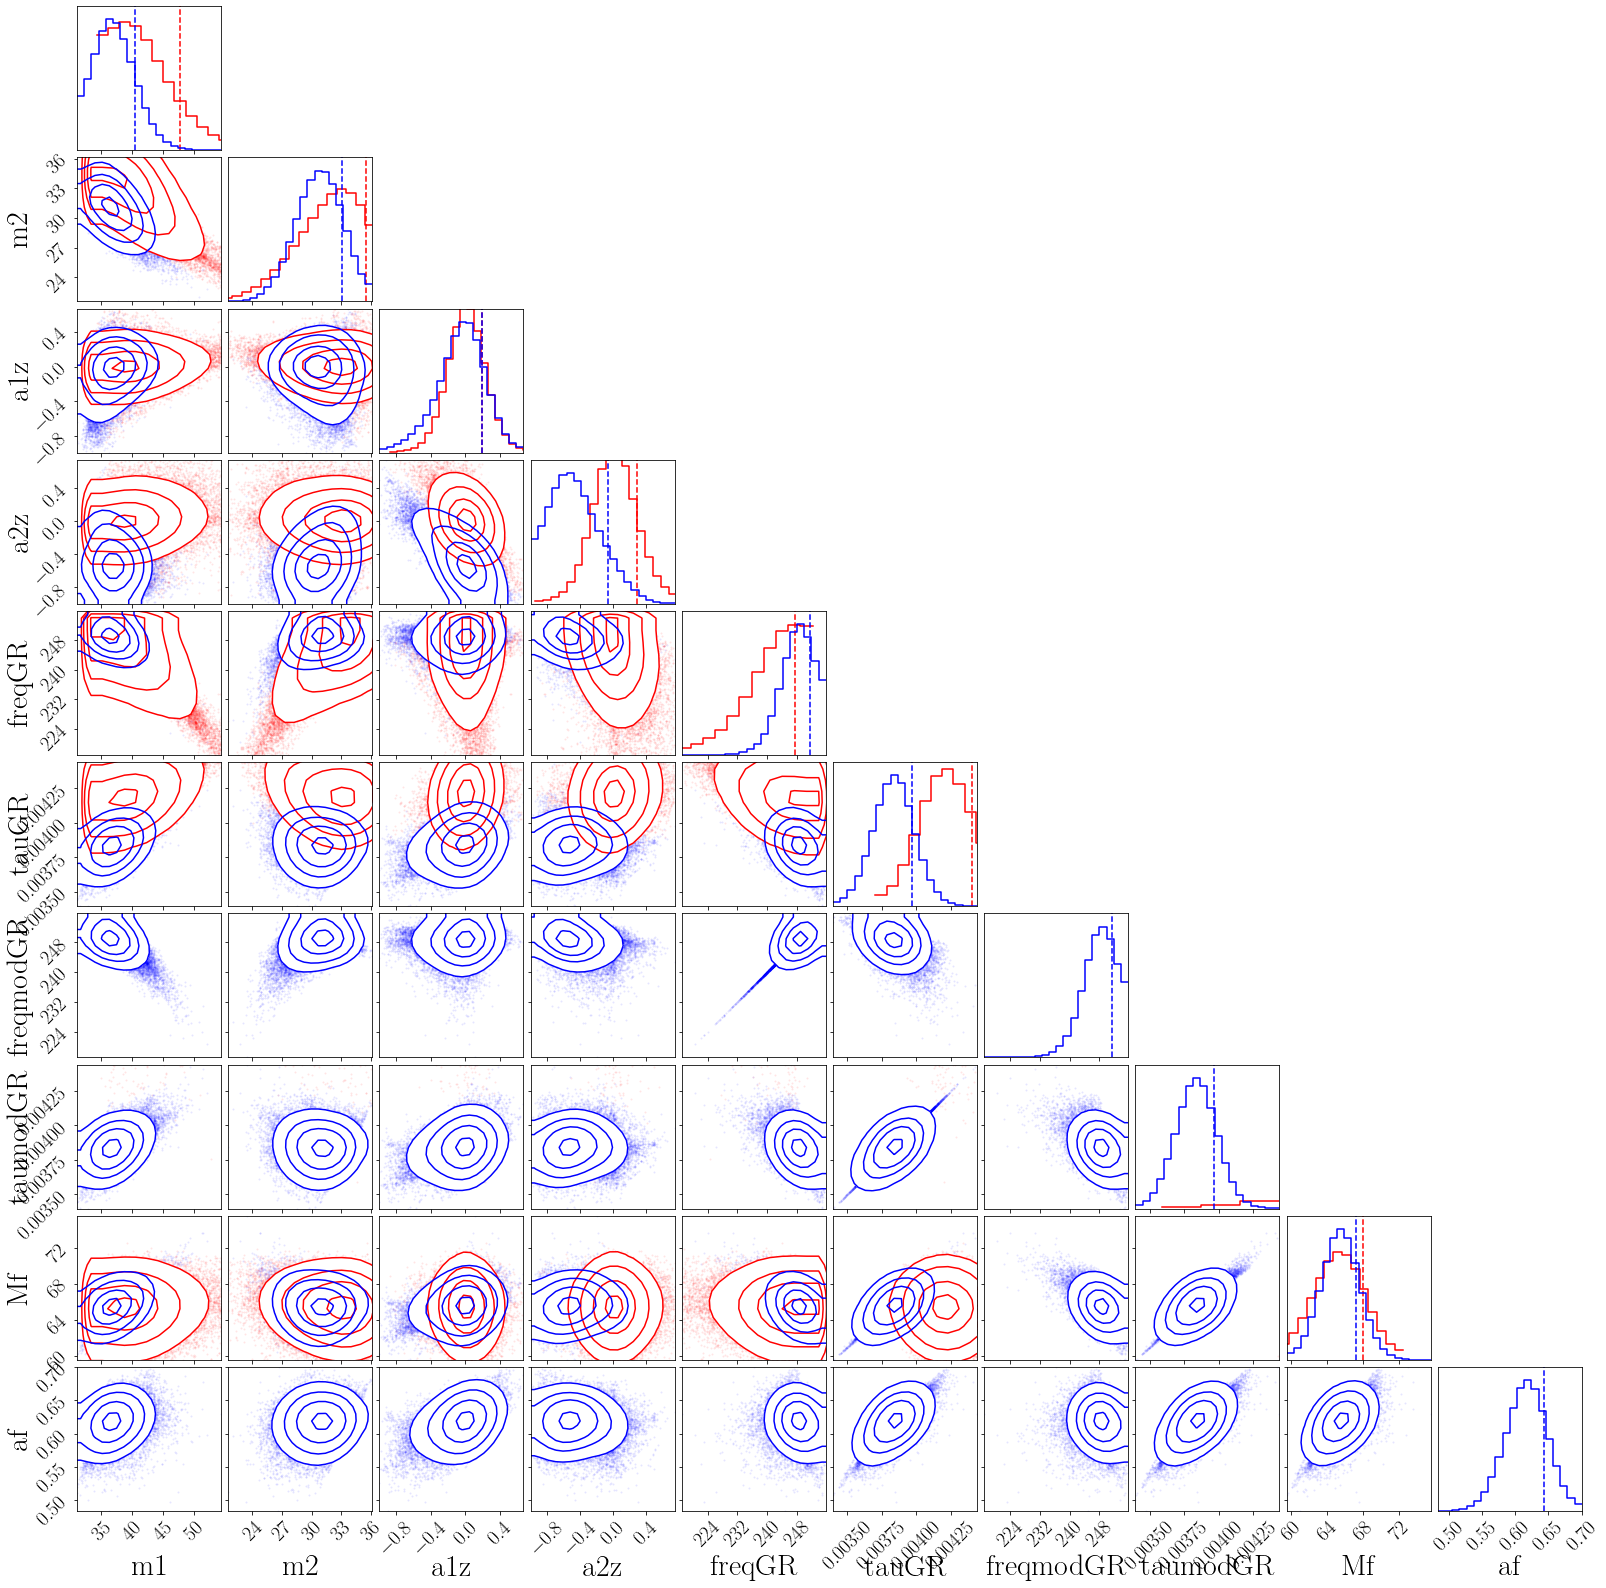

In [5]:
data = data_dict['GW150914']['0p5']
m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
samples_ngr = np.vstack([m1, m2, a1z, a2z, freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af]).T

data = data_dict['GW150914']['0p5_GR']
m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
samples_gr = np.vstack([m1, m2, a1z, a2z, freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af]).T

fig = corner.corner(samples_ngr, color='red', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None)
corner.corner(samples_gr, fig=fig, color='blue', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None, \
                    labels=['m1', 'm2', 'a1z', 'a2z', 'freqGR', 'tauGR', 'freqmodGR', 'taumodGR', 'Mf', 'af'])
plt.show()

### GW190521: 0p0: pSEOB vs SEOB comparison

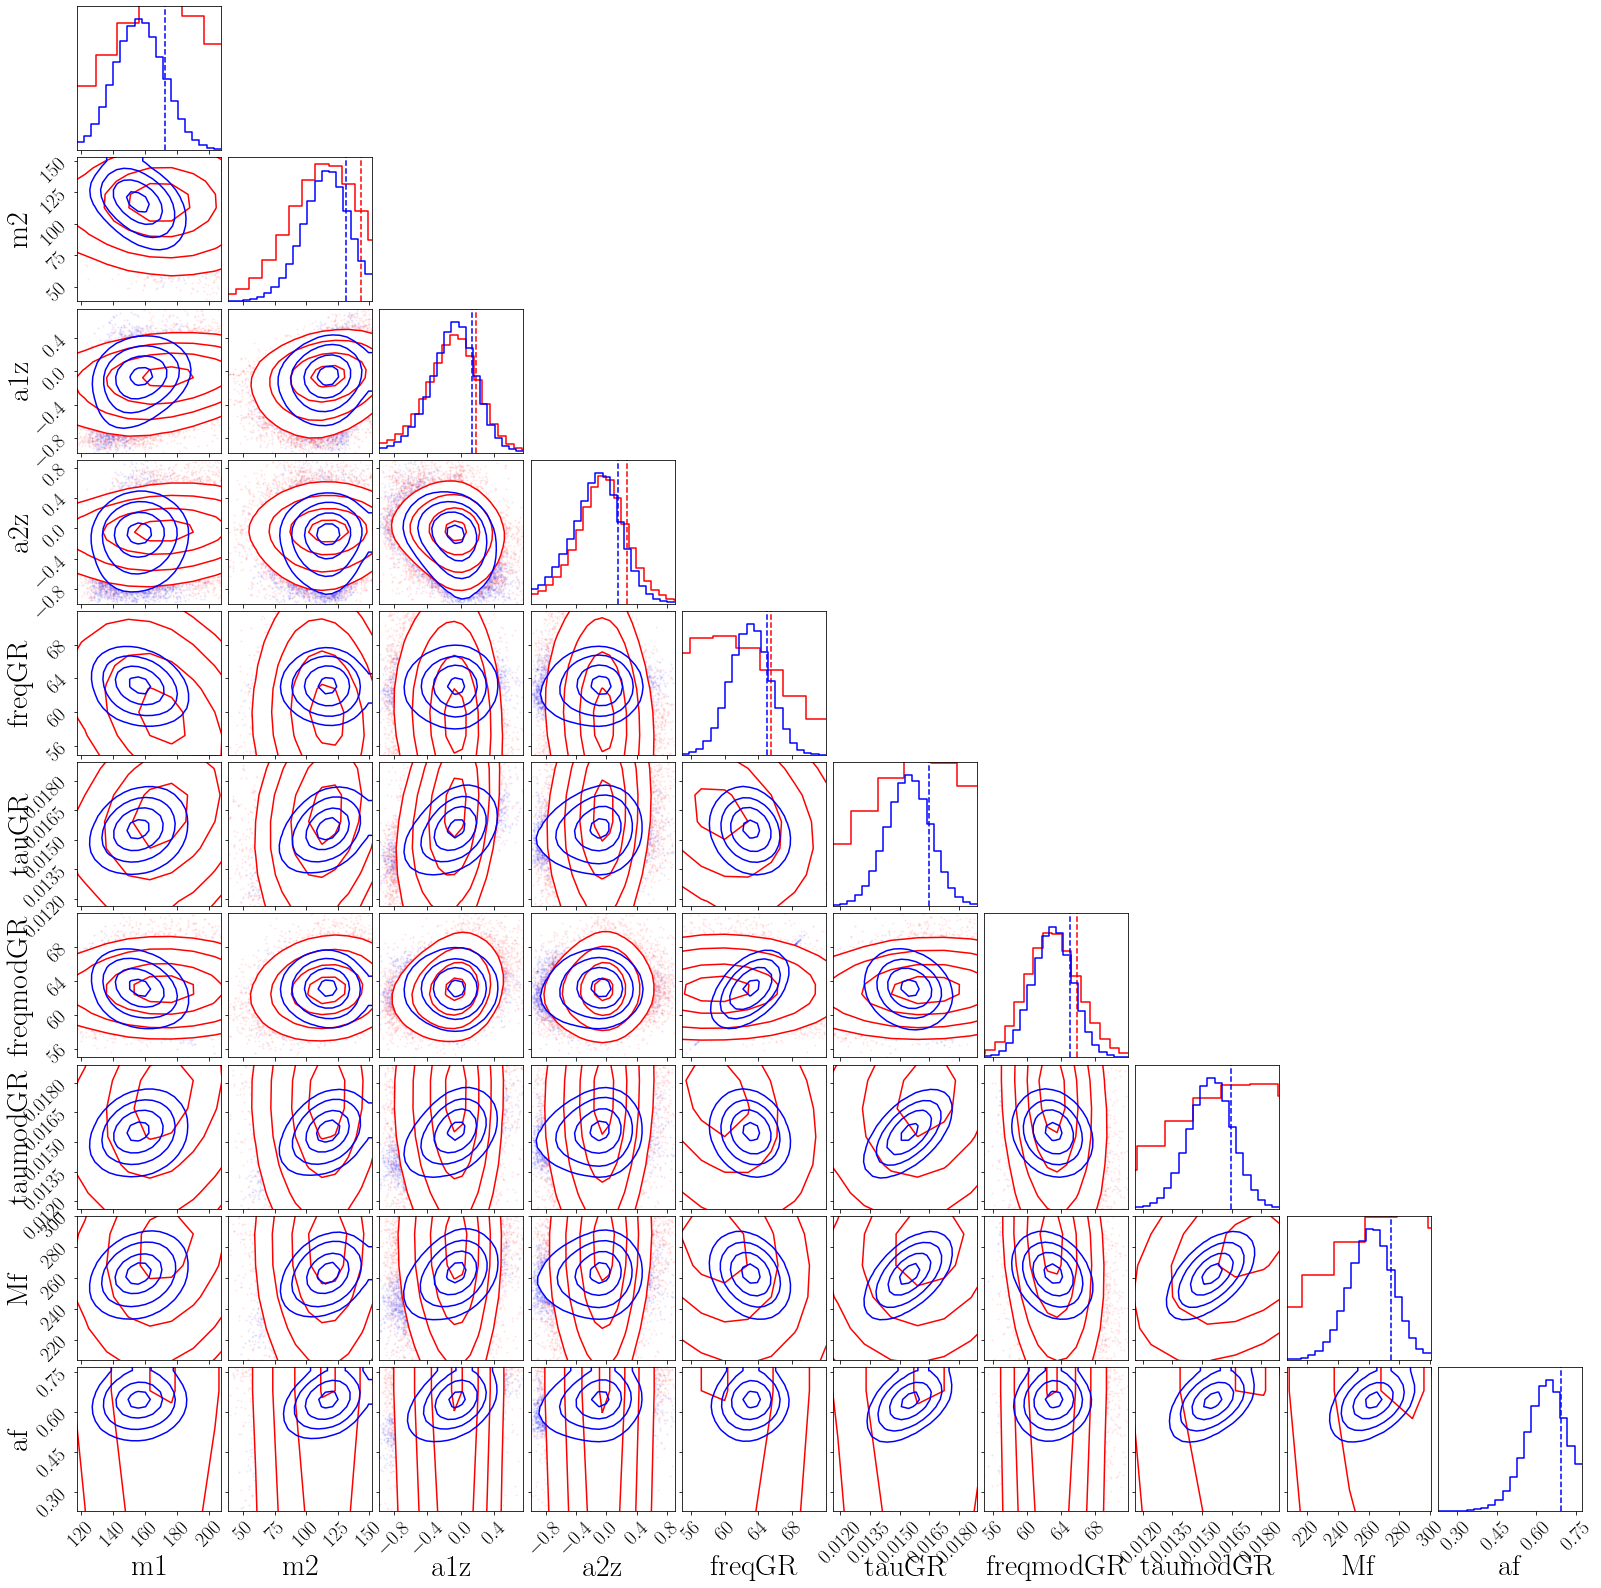

In [6]:
data = data_dict['GW190521']['0p0']
m1, m2, a1z, a2z, domega, dtau = data["m1"], data["m2"], data["a1z"], data["a2z"], data["domega220"], data["dtau220"]
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
samples_ngr = np.vstack([m1, m2, a1z, a2z, freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af]).T

data = data_dict['GW190521']['0p0_GR']
m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
domega, dtau = np.zeros(len(m1)), np.zeros(len(m1))
freq_GR, tau_GR, freq_modGR, tau_modGR = eff_quant(m1, m2, a1z, a2z, domega, dtau, [2,2])
Mf, af = Mjfinal220(2.*np.pi*freq_modGR,tau_modGR)
samples_gr = np.vstack([m1, m2, a1z, a2z, freq_GR, tau_GR, freq_modGR, tau_modGR, Mf, af]).T

fig = corner.corner(samples_ngr, color='red', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None)
corner.corner(samples_gr, fig=fig, color='blue', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None, \
                    labels=['m1', 'm2', 'a1z', 'a2z', 'freqGR', 'tauGR', 'freqmodGR', 'taumodGR', 'Mf', 'af'])
plt.show()

### GW190521: 0p5: pSEOB vs SEOB comparison

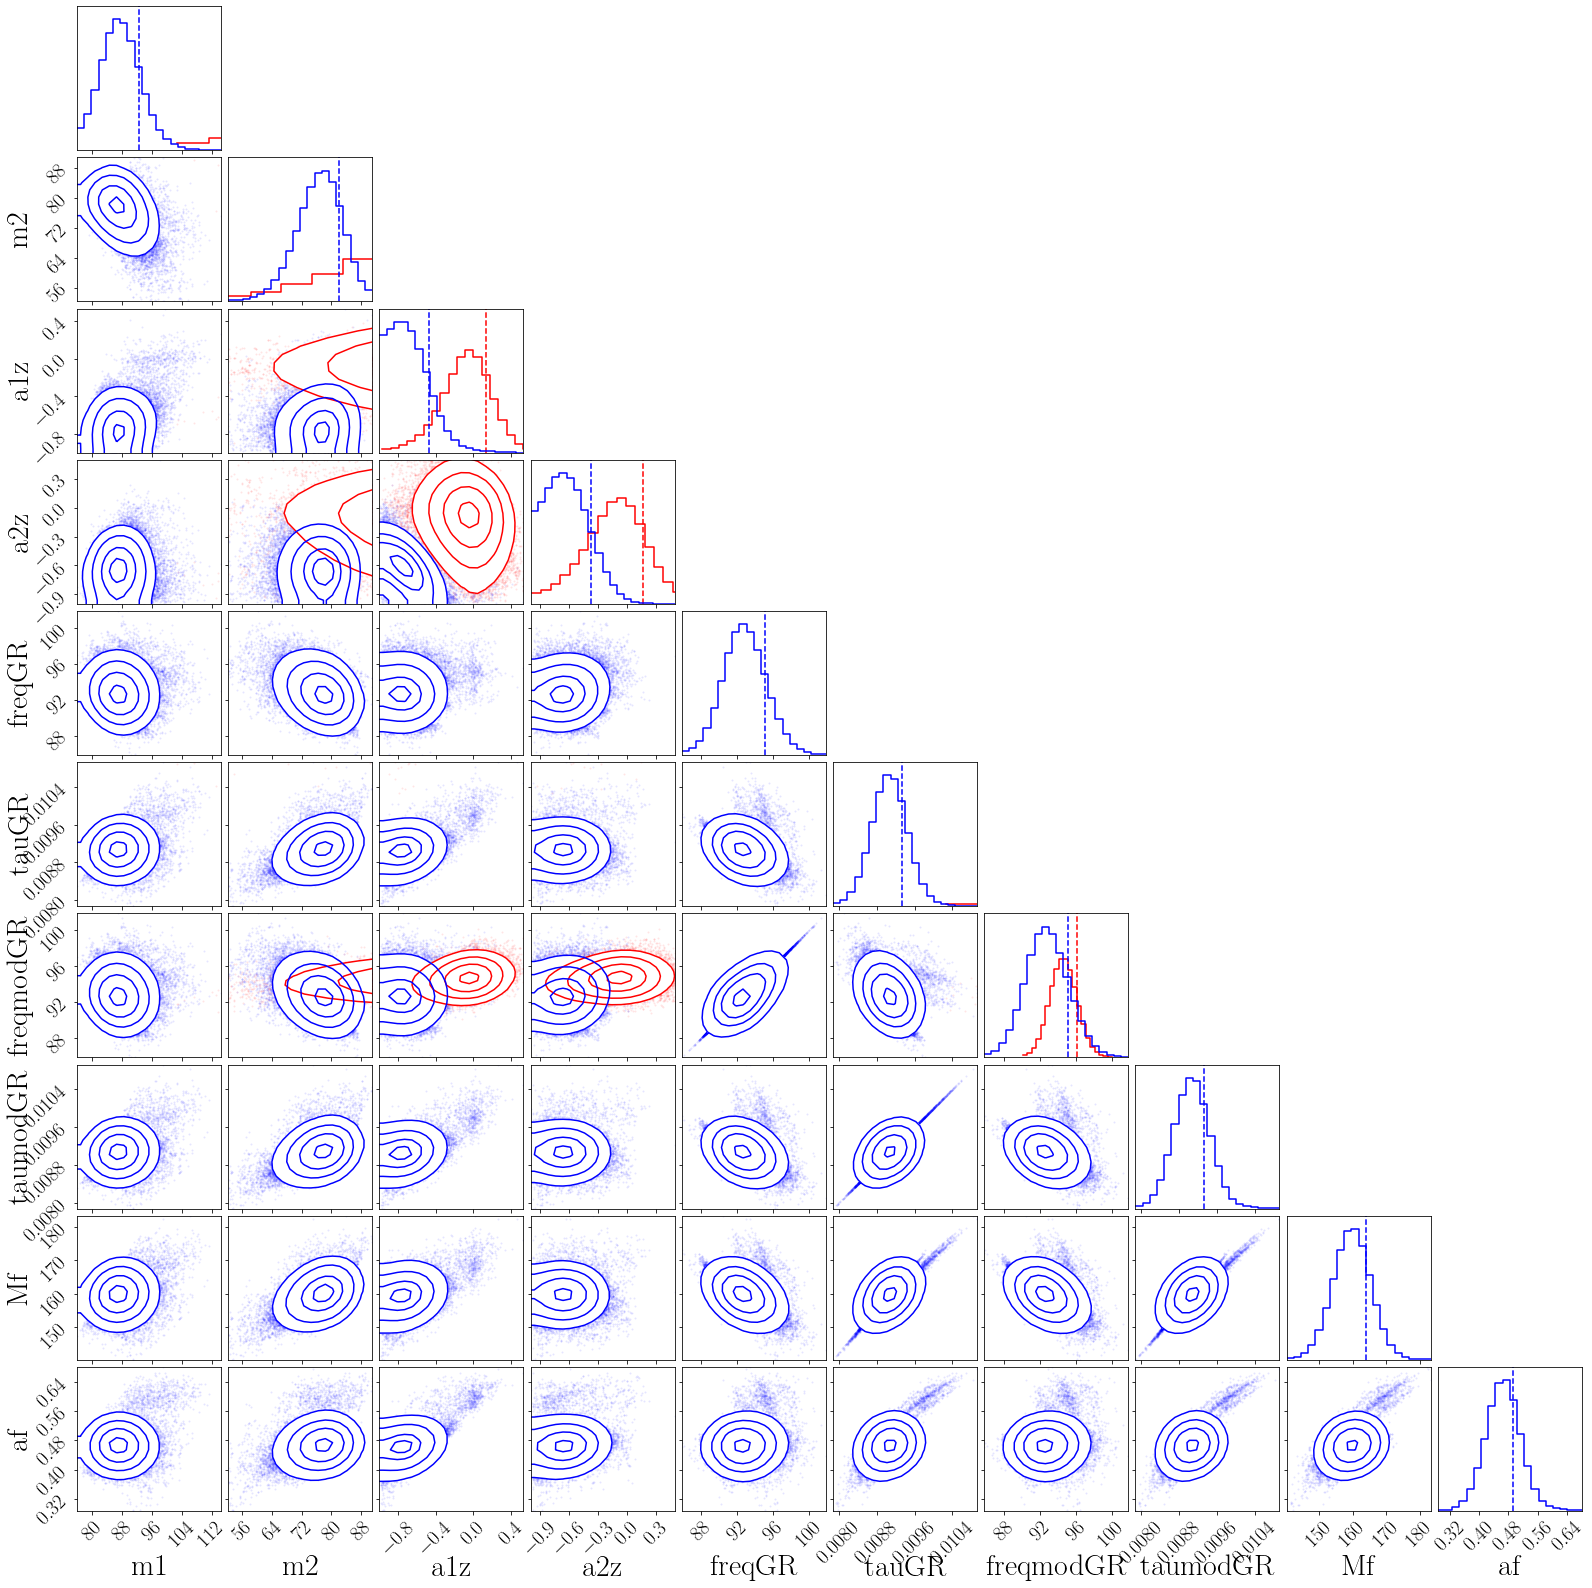

In [7]:
data_ngr = data_dict['GW190521']['0p5']
m1_ngr, m2_ngr, a1z_ngr, a2z_ngr, domega_ngr, dtau_ngr = data_ngr["m1"], data_ngr["m2"], \
data_ngr["a1z"], data_ngr["a2z"], data_ngr["domega220"], data_ngr["dtau220"]
freq_GR_ngr, tau_GR_ngr, freq_modGR_ngr, tau_modGR_ngr = eff_quant(m1_ngr, m2_ngr, a1z_ngr, \
                                                        a2z_ngr, domega_ngr, dtau_ngr, [2,2])
Mf_ngr, af_ngr = Mjfinal220(2.*np.pi*freq_modGR_ngr,tau_modGR_ngr)
samples_ngr = np.vstack([m1_ngr, m2_ngr, a1z_ngr, a2z_ngr, freq_GR_ngr, tau_GR_ngr, \
                         freq_modGR_ngr, tau_modGR_ngr, Mf_ngr, af_ngr]).T

data_gr = data_dict['GW190521']['0p5_GR']
m1_gr, m2_gr, a1z_gr, a2z_gr = data_gr["m1"], data_gr["m2"], data_gr["a1z"], data_gr["a2z"]
domega_gr, dtau_gr = np.zeros(len(m1_gr)), np.zeros(len(m1_gr))
freq_GR_gr, tau_GR_gr, freq_modGR_gr, tau_modGR_gr = eff_quant(m1_gr, m2_gr, \
                                                    a1z_gr, a2z_gr, domega_gr, dtau_gr, [2,2])
Mf_gr, af_gr_gr = Mjfinal220(2.*np.pi*freq_modGR_gr,tau_modGR_gr)
samples_gr = np.vstack([m1_gr, m2_gr, a1z_gr, a2z_gr, freq_GR_gr, tau_GR_gr, \
                        freq_modGR_gr, tau_modGR_gr, Mf_gr, af_gr]).T

ranges = [[min(min(m1_ngr), min(m1_gr)), max(max(m1_ngr), max(m1_gr))], \
         [min(min(m2_ngr), min(m2_gr)), max(max(m2_ngr), max(m2_gr))], \
         [min(min(a1z_ngr), min(a1z_gr)), max(max(a1z_ngr), max(a1z_gr))], \
         [min(min(a2z_ngr), min(a2z_gr)), max(max(a2z_ngr), max(a2z_gr))], \
         [min(min(freq_GR_ngr), min(freq_GR_gr)), max(max(freq_GR_ngr), max(freq_GR_gr))], \
         [min(min(tau_GR_ngr), min(tau_GR_gr)), max(max(tau_GR_ngr), max(tau_GR_gr))], \
         [min(min(freq_modGR_ngr), min(freq_modGR_gr)), max(max(freq_modGR_ngr), max(freq_modGR_gr))], \
         [min(min(tau_modGR_ngr), min(tau_modGR_gr)), max(max(tau_modGR_ngr), max(tau_modGR_gr))], \
         [min(min(Mf_ngr), min(Mf_gr)), max(max(Mf_ngr), max(Mf_gr))], \
         [min(min(af_ngr), min(af_gr)), max(max(af_ngr), max(af_gr))]]

fig = corner.corner(samples_ngr, color='red', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None)
corner.corner(samples_gr, fig=fig, color='blue', smooth=2., smooth1d=2.0, \
                    quantiles=[0.9], plot_density=None, \
                    labels=['m1', 'm2', 'a1z', 'a2z', 'freqGR', 'tauGR', 'freqmodGR', 'taumodGR', 'Mf', 'af'])
plt.show()